# Make $A_s$ maps

In [112]:
#set up values and functions
#------packages-------------------
%pylab inline

import healpy as hp

#-------constants------------------
TCMB = 2.7255  # Kelvin
hplanck = 6.626070150e-34  # MKS
kboltz = 1.380649e-23  # MKS


#-------functions------------------
#defines the ell power law that we will use for the A_s spectrum
def powerlaw(ell, alpha):
    return (ell/ 80.)**alpha

#defines a normal planck distribution 
def normed_cmb_thermo_units(nu):
    X = hplanck * nu / (kboltz * TCMB)
    eX = np.exp(X)
    return eX * X**4 / (eX - 1.)**2

#define the synchrotron SED.
#define what frequency map we want to look at. Start with 2.3 GHz
nu0 = 2.3e9 

def normed_synch(nu, beta):
    if beta is not np.array:
        beta = np.array(beta)
    return (nu/nu0)**(2.+beta[..., np.newaxis])

def scale_synch(nu, beta):
    unit = normed_synch(nu, beta) * normed_cmb_thermo_units(nu0) / normed_cmb_thermo_units(nu)
    return unit


#-------BB parameters (to start)--------
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2

#-------map paramters--------------------
nside = 128
Lmax = 384
ells = np.arange(1,Lmax+1)

Populating the interactive namespace from numpy and matplotlib


In [114]:
"""
----Notation used in this notebook----

ells    - the ells up to ell_max = 384
pcls    - the power law C_ell defined through pcls = (ell/80)^alpha_BB
check_cls - the extracted C_ell from a map using anafast

sbb     - the power law map in ell. This will be used for all complete maps, as we're only modifying the frequency dep.


sed_scaling_<x> - the scaled_synch function on frequencies and some beta. Up to unit conversion this is (nu/nu_0)^beta
                  where beta is either just a constant or is a whole map of betas


newmaps_<x>    - newmaps_<x> = sbb * sed_scaling_<x>. This is a series of 'real' frequency maps

""";

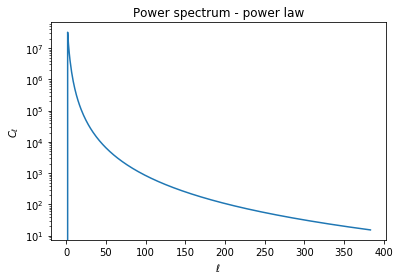

In [115]:
#define C_ell with a power law dependence on ell
pcls = A_BB * powerlaw(ells, alpha_BB)
pcls[0] = 0 
pcls[1] = 0

#shift the ells to start at 0
ells = ells-1


#input power spectrum
semilogy(ells,pcls)
xlabel("$\ell$")
ylabel("$C_\ell$")
title("Power spectrum - power law");



Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


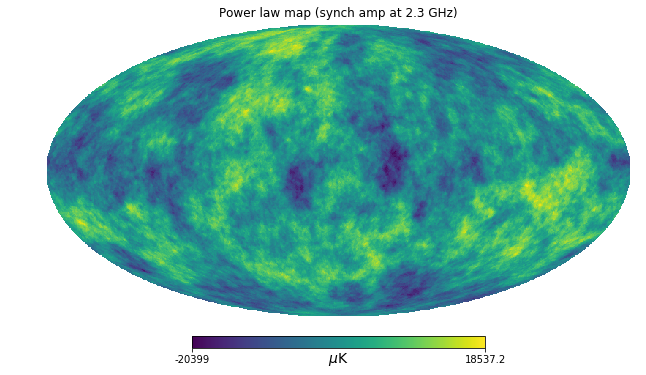

In [116]:
#produce power law map
sbb = hp.synfast(pcls, nside, new=True)
hp.mollview(sbb, unit=r'$\mu \rm K$', title='Power law map (synch amp at 2.3 GHz)')

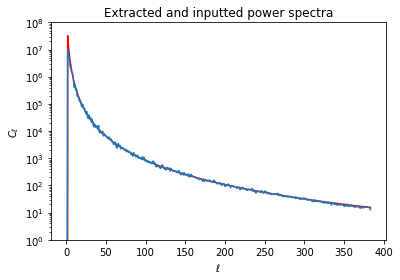

In [117]:

#compare the measured C_ell to the input C_ell curve
check_cls = hp.anafast(sbb)


semilogy(ells, pcls, 'r')
semilogy(ells, check_cls)
xlabel("$\ell$")
ylabel("$C_\ell$")
title("Extracted and inputted power spectra")
ylim(1, 1e8);

# Produce maps including the SED

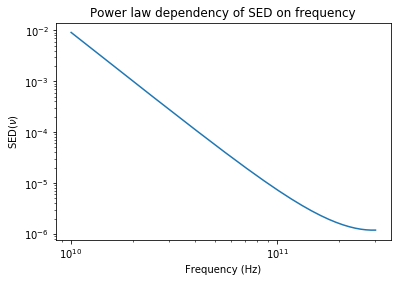

In [7]:
#define list of frequencies going from 10 to 300 GHz, sampling 20 points
freqs = np.linspace(10,300,20)*1.e9


#define the SED scaling
sed_scaling_const = scale_synch(freqs, beta_BB)


#plot the SED against frequency (on log log plot)
loglog(freqs, sed_scaling_const)
xlabel("Frequency (Hz)")
ylabel(r"$\mathrm{SED}(\nu)$") #the r is needed for the LaTeX
title("Power law dependency of SED on frequency");

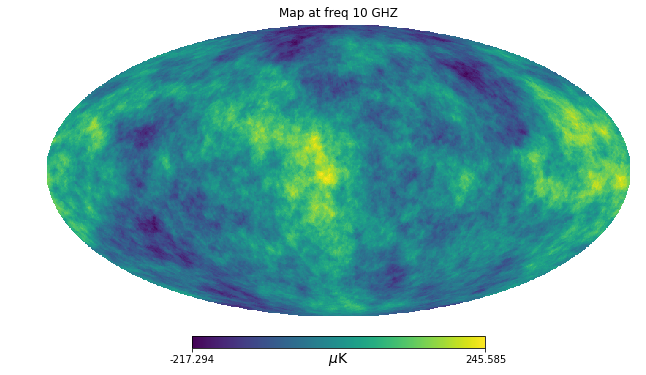

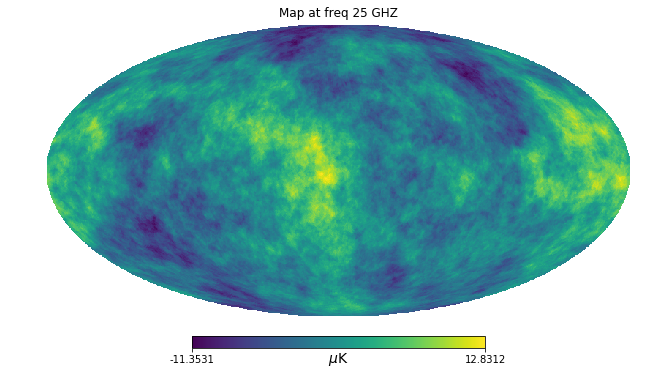

In [8]:
#the maps including SED at different frequencies
newmaps_const = sbb * sed_scaling_const[..., np.newaxis]

for k in range(2): #can extend this range up to 20 to get all the maps
    hp.mollview(newmaps_const[k], title = "Map at freq %d GHZ" %(1e-9*freqs[k]), unit = r"$\mu \rm K$")
    


# Allow $\beta$ to vary (uniform $C_\ell^\beta$).

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
mean of beta map = -3.1999999999999997
std of beta map = 0.13298752982226822


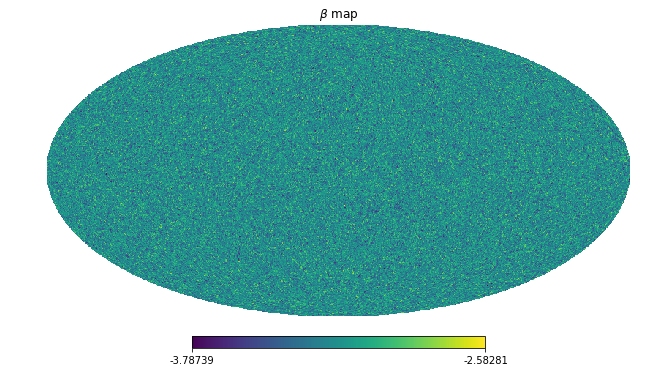

In [9]:
#define a standard deviation that gives rise to a map about the size
#expected

beta_sigma = 1.5e-6

#define a 'beta map' using uniform C_ell
beta_cls_uniform = beta_sigma * ones_like(ells)  #makes a vector [1.5e-6, ... , 1.5e-6] with the same shape as the ells
beta_map_uniform = hp.synfast(beta_cls_uniform, nside, new=True)

#update the map so that the mean is correct
beta_map_uniform -= (np.mean(beta_map_uniform) + 3.2)

#check map is as expected: mean ~3.2, std ~0.1
print("mean of beta map = " + str(np.mean(beta_map_uniform)))
print("std of beta map = " + str(np.std(beta_map_uniform)))

#view beta map
hp.mollview(beta_map_uniform, title=r"$\beta \ \rm map$")

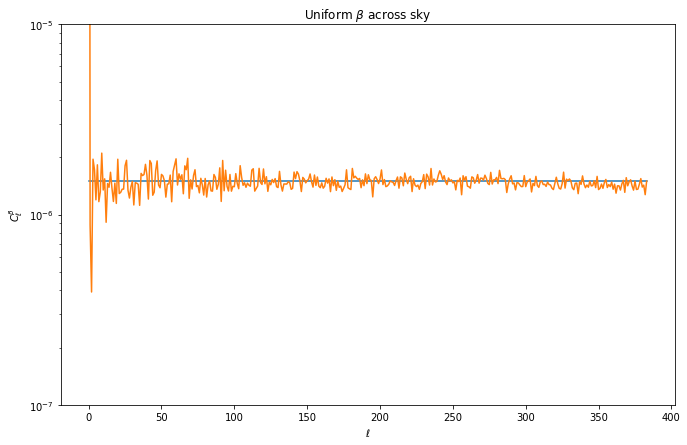

In [10]:
#check beta_cls from this map compared to input (uniform spectrum)
check_bcls_uniform = hp.anafast(beta_map_uniform)

figure(figsize=(11,7))
semilogy(ells, beta_cls_uniform)
semilogy(ells, check_bcls_uniform)
ylim(1e-7, 1e-5)
xlabel("$\ell$")
ylabel(r"$ C_\ell^{\beta}$") 
title(r"Uniform $\beta$ across sky");

In [12]:
np.std(beta_map_uniform)

0.13298752982226822

In [13]:
beta_map_uniform.shape

(196608,)

# Use this $\beta$ to make a series of maps

(196608, 20)
(20,)
(20,)


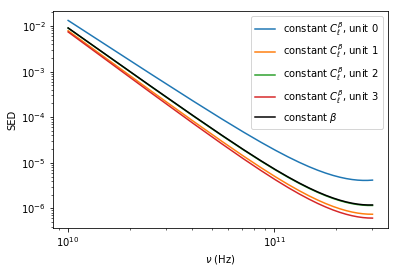

In [22]:
#we now want to take (nu/nu_0)^beta_map

#define the new, varying SED
sed_scaling_uniform = scale_synch(freqs, beta_map_uniform) 
# print(np.mean(sed_scaling_uniform, axis=0))
# print(sed_scaling_const)


print(sed_scaling_uniform.shape)
print(freqs.shape)
print(sed_scaling_const.shape)

for k in range(4):
    loglog(freqs, sed_scaling_uniform[k], label=r"constant $C_\ell^\beta$, unit %d" %k)
loglog(freqs, sed_scaling_const, 'k', label=r"constant $\beta$")
xlabel(r'$\nu$ (Hz)')
ylabel('SED')
legend();
#this is the variation with frequency of the first few pixels in the map


#now transpose the SED so that we can multiply it by our map
sed_scaling_uniform = sed_scaling_uniform.T

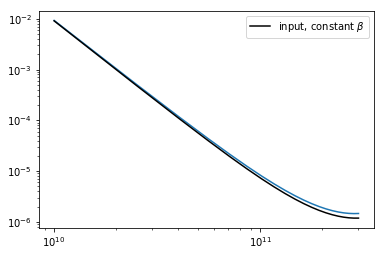

In [23]:
#comparing the input spectrum (x_const) and the mean of the uniform C_ell

loglog(freqs, np.mean(sed_scaling_uniform,1))
loglog(freqs, sed_scaling_const, 'k', label=r"input, constant $\beta$")
legend();

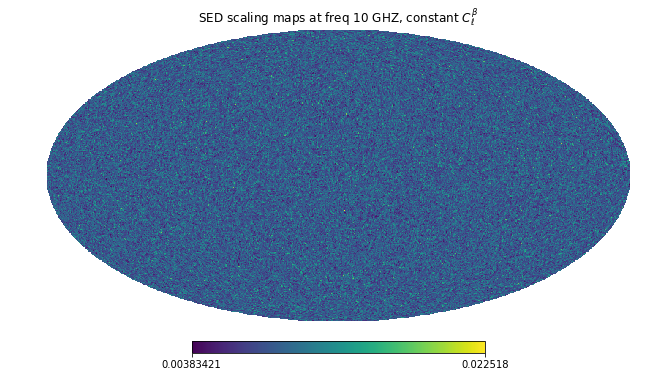

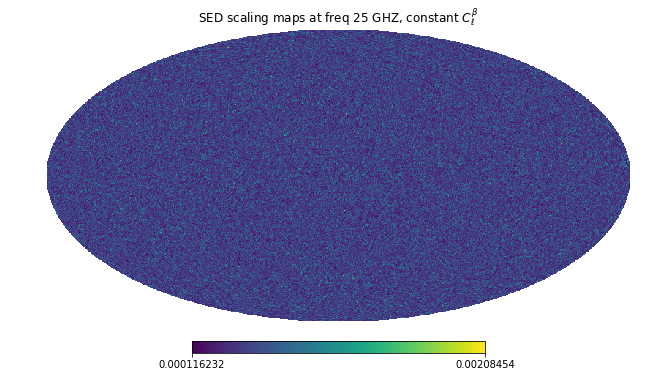

In [24]:
for k in range(2): #can extend this range up to 20 to get all the maps
    hp.mollview(sed_scaling_uniform[k], title = r"SED scaling maps at freq %d GHZ, constant $C_\ell^\beta$" %(1e-9*freqs[k]))
    

# Create the "realistic maps" by multiplying the $\beta$ map and the $A_s$ map together

In [25]:
#----constant beta maps----
#the maps with constant beta are already "realistic", so can just use newmaps_const


#----uniform C_ell from beta
#the maps formed so far from the beta stuff do not include A_s, so must multiply by sbb
#this is what Max calls x in his code
newmaps_uniform = sbb * sed_scaling_uniform

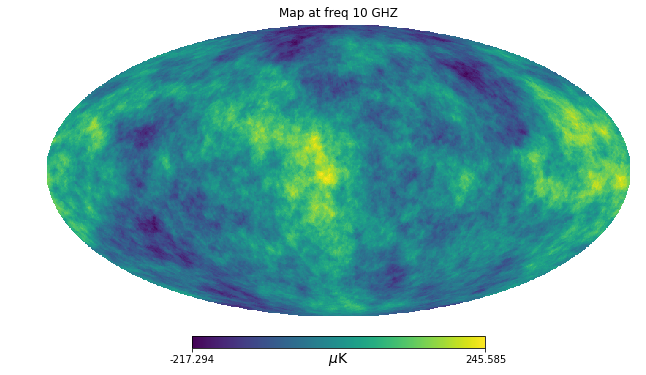

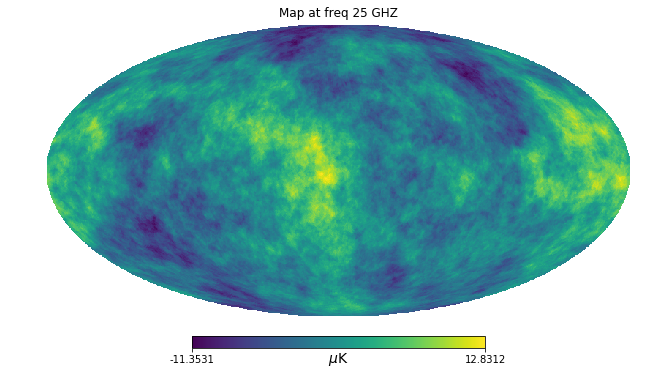

In [26]:
#---constant beta map----
#---these are the same as the frequency maps produced in the first part----

for k in range(2): #can extend this range up to 20 to get all the maps
    hp.mollview(newmaps_const[k], title = "Map at freq %d GHZ" %(1e-9*freqs[k]), unit = r"$\mu \rm K$")

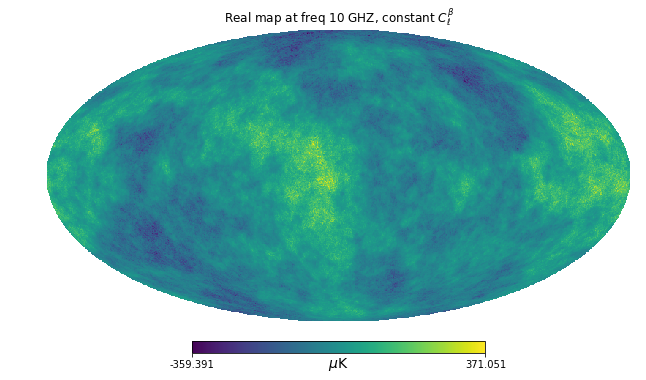

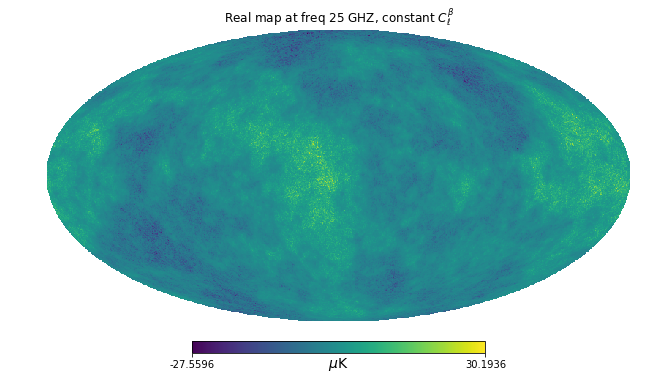

In [27]:
#----uniform C_ell from beta (varying beta)----

for k in range(2): #can extend this range up to 20 to get all the maps
    hp.mollview(newmaps_uniform[k], title = r"Real map at freq %d GHZ, constant $C_\ell^\beta$" %(1e-9*freqs[k]), unit = r"$\mu \rm K$")
    


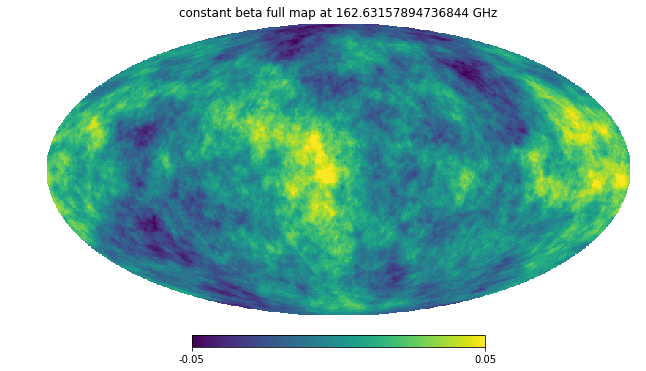

In [28]:
#more interesting to view where they start to deviate more (further from nu_0)

hp.mollview(newmaps_const[10], min=-0.05, max=0.05, title="constant beta full map at " +str(freqs[10]*1e-9) + " GHz")

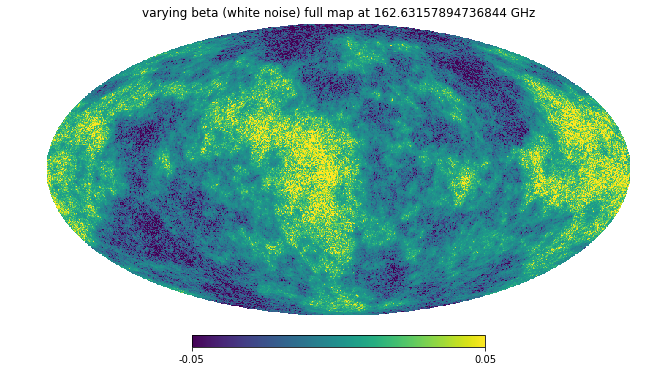

In [29]:
#force it onto the same scale
hp.mollview(newmaps_uniform[10], min=-0.05, max=0.05, title=r"varying beta (white noise) full map at " + str(freqs[10]*1e-9) + " GHz")

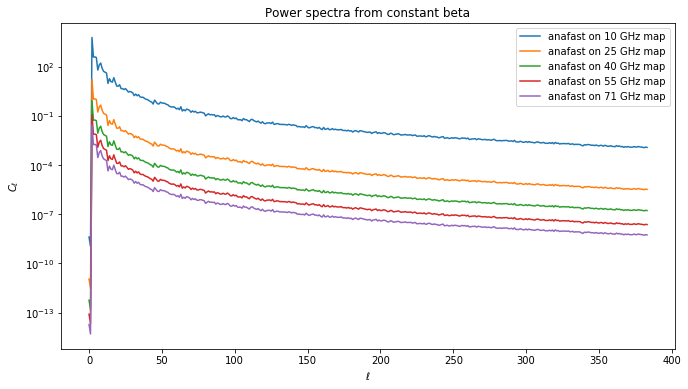

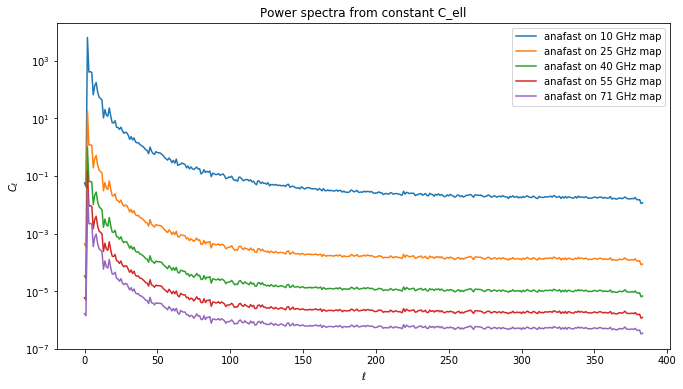

In [30]:
#extract power spectra

#-------constant beta------------------------
figure(figsize=(11,6))
for k in range(5): #could go up to 20
    semilogy(ells, hp.anafast(newmaps_const[k]), label='anafast on %d GHz map' %(1e-9*freqs[k]))
    ylabel('$C_\ell$')
    xlabel('$\ell$')
    legend(loc=1)
    title("Power spectra from constant beta")
    
#------constant C_ell from the beta map------
figure(figsize=(11,6))
for k in range(5): #again, could go up to 20
    semilogy(ells, hp.anafast(newmaps_uniform[k]), label='anafast on %d GHz map' %(1e-9*freqs[k]))
    ylabel('$C_\ell$')
    xlabel('$\ell$')
    legend()
    title("Power spectra from constant C_ell")

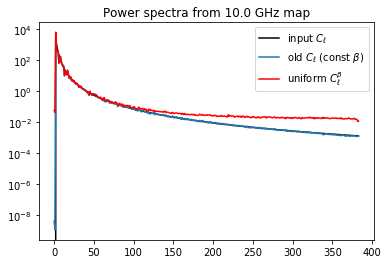

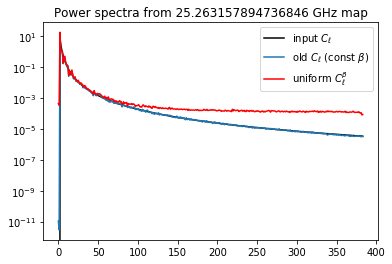

In [32]:
#need to compare this to the input spectra

for k in range(2): #can go up to 20
    figure()
    theory_cls = pcls*sed_scaling_const[k]**2     #input c_ell
    old_cls = hp.anafast(newmaps_const[k])        #the input c_ell
    new_cls = hp.anafast(newmaps_uniform[k])      #the c_ell from constant c_ell from the beta
    
    semilogy(ells, theory_cls, 'k', label=r"input $C_\ell$")
    semilogy(ells, old_cls, label=r"old $C_\ell$ (const $\beta$)")
    semilogy(ells, new_cls, 'r', label=r"uniform $C_\ell^\beta$")
    title("Power spectra from " + str(1e-9*freqs[k]) + " GHz map" )
    legend()



# Let's make some histograms

we can make histograms of the
   - $A_s$ map (``sbb``)
   - $\beta_s$ map (``beta_map_uniform``) 
   - Frequency maps with constant and varying $\beta$
       - ``newmaps_const``
       - ``newmaps_uniform``

In [46]:
from scipy.stats import kstest, norm

In [57]:
#start with amplitude maps


print(np.mean(sbb))
print(np.std(sbb))

0.03628963723482078
7648.254930586608


In [58]:
x_sbb = np.linspace(-5*np.std(sbb), 5*np.std(sbb))
y_sbb = norm(np.mean(sbb),np.std(sbb))

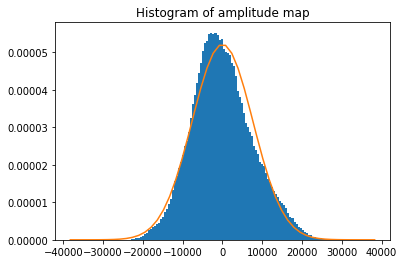

In [66]:
#the amplitude map histogram
hist(sbb, bins=100,density=True);
plot(x_sbb, y_sbb.pdf(x_sbb));
title(r'Histogram of amplitude map');

In [62]:
print(np.mean(beta_map_uniform))
print(np.std(beta_map_uniform))

-3.1999999999999997
0.13298752982226822


In [63]:
x_beta = np.linspace(-3.8,-2.6)
y_beta = norm(-3.2, np.std(beta_map_uniform))

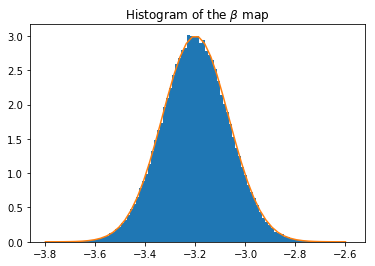

In [64]:
#the beta map histogram

hist(beta_map_uniform, bins=100, density=True)
plot(x_beta,y_beta.pdf(x_beta))
title(r"Histogram of the $\beta$ map");

(20,)

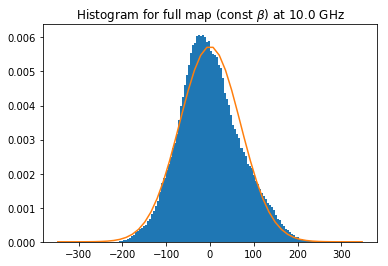

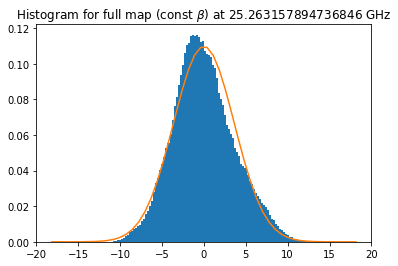

In [79]:
#full maps with constant beta
for k in range(2):
    figure()
    mu = np.mean(newmaps_const[k])
    sigma = np.std(newmaps_const[k])
    x = np.linspace(mu-5*sigma, mu+5*sigma)
    y= norm(mu,sigma)

    hist(newmaps_const[k], bins=100, density=True)
    plot(x, y.pdf(x))
    title(r"Histogram for full map (const $\beta$) at " + str(freqs[k]*1e-9) + " GHz")

# This looks different to Max's

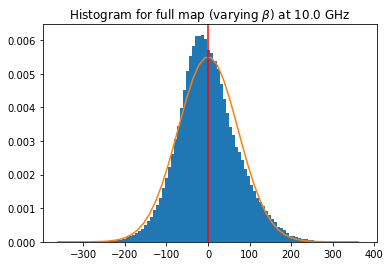

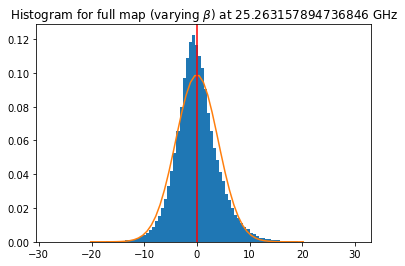

In [83]:
#full maps with varying beta
for k in range(2):
    figure()
    mu = np.mean(newmaps_uniform[k])
    sigma = np.std(newmaps_uniform[k])
    x = np.linspace(mu-5*sigma, mu+5*sigma)
    y= norm(mu,sigma)

    hist(newmaps_uniform[k], bins=100, density=True)
    plot(x, y.pdf(x))
    axvline(sed_scaling_const[k], color='r') #vertical line corresponding to 
    title(r"Histogram for full map (varying $\beta$) at " + str(freqs[k]*1e-9) + " GHz")
    
    
    
    #unsure what this red line corresponds to

# Moment expansion

In [86]:
from pyshtools.utils import Wigner3j
#whether this package is suitable for the high ell stuff is questionable, look into other implimentations
#of Wigner 3j symbols

In [90]:
#not totally sure what this is doing?

total = np.zeros(800)
for ell1 in ells[1:-1]:
    for ell2 in ells[1:-1]:
        w3j, ellmin, ellmax = Wigner3j(ell1, ell2, 0, 0, 0)
        indexmax = np.where(w3j!=0)[0][-1] + 1
        ellmax += 1
        norm = (2. *ell1 + 1) * (2. * ell2 + 1) / (4*pi)
        total[ellmin:ellmax] = total[ellmin:ellmax] + norm * w3j[:indexmax]**2 * powerlaw(ell1, alpha_BB) * 1.5e-6
    


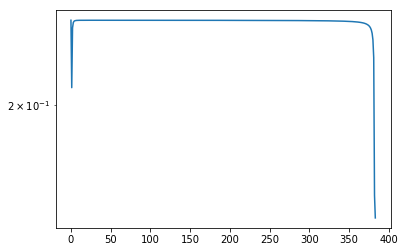

In [120]:
semilogy(total[:384])

In [125]:
#I haven't got a clue what's going on here